In [45]:
import pickle
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random
import sys
import os
from math import floor
import pandas as pd
import seaborn as sn
import datetime
from IPython.display import clear_output

#For models
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from statsmodels.discrete.discrete_model import Probit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans

from sklearn.metrics import precision_recall_curve

    
def pc(x,X, dec=1):
    return str(round(100*(x/X),dec))+"%"

MULTIPLE_FAKES = 100
NJOBS=2
DFA_chosen = None

# Importing DFA - MANUAL IMPUT REQUIRED

In [46]:
if not(DFA_chosen):
    !/usr/bin/env ls output_data/working_data/ | grep DFA
    DFA_chosen = input('Choose a DFA in the list above')

DFA.p
DFA_1to50-0.9%.p
DFA_1to50-1.0%.p
DFA_30to50-1.3%.p
DFA_30to50.p
DFA_8to201.2%.p
DFA_8to201.3%.p
DFA_cnt_superior_to_50.p
DFA_greater_than_50-0.1%.p
DFA_greater_than_50-1.3%.p
DFA_no_condition-0.9%.p
DFAsmall1.p
Choose a DFA in the list aboveDFA_no_condition-0.9%.p


In [54]:
DFA_chosen="DFA_no_condition-0.9%.p"

In [55]:
with open('output_data/working_data/{}'.format(DFA_chosen), 'rb') as f :
    DFA = pickle.load(f)
    #Get rid of base links and shuffle it
    DFA = DFA[DFA['BASE']==0].sample(frac=1).drop(['BASE'],axis=1)
    
print("■ YOU IMPORTED //{}// SUCCESSFULLY".format(DFA_chosen))
Ntargets = DFA['TARGET'].sum()
Ncandidates = DFA.shape[0]
print(Ntargets, Ncandidates, "--", pc(Ntargets,Ncandidates), "of target links ")

■ YOU IMPORTED //DFA_no_condition-0.9%.p// SUCCESSFULLY
12436 1405662 -- 0.9% of target links 


In [78]:
print("■ YOU IMPORTED //{}// SUCCESSFULLY".format(DFA_chosen))
Ntargets = DFA['TARGET'].sum()
Ncandidates = DFA.shape[0]
print(Ntargets, Ncandidates, "--", pc(Ntargets,Ncandidates,2), "of target links ")

■ YOU IMPORTED //DFA_no_condition-0.9%.p// SUCCESSFULLY
12436 1405662 -- 0.88% of target links 


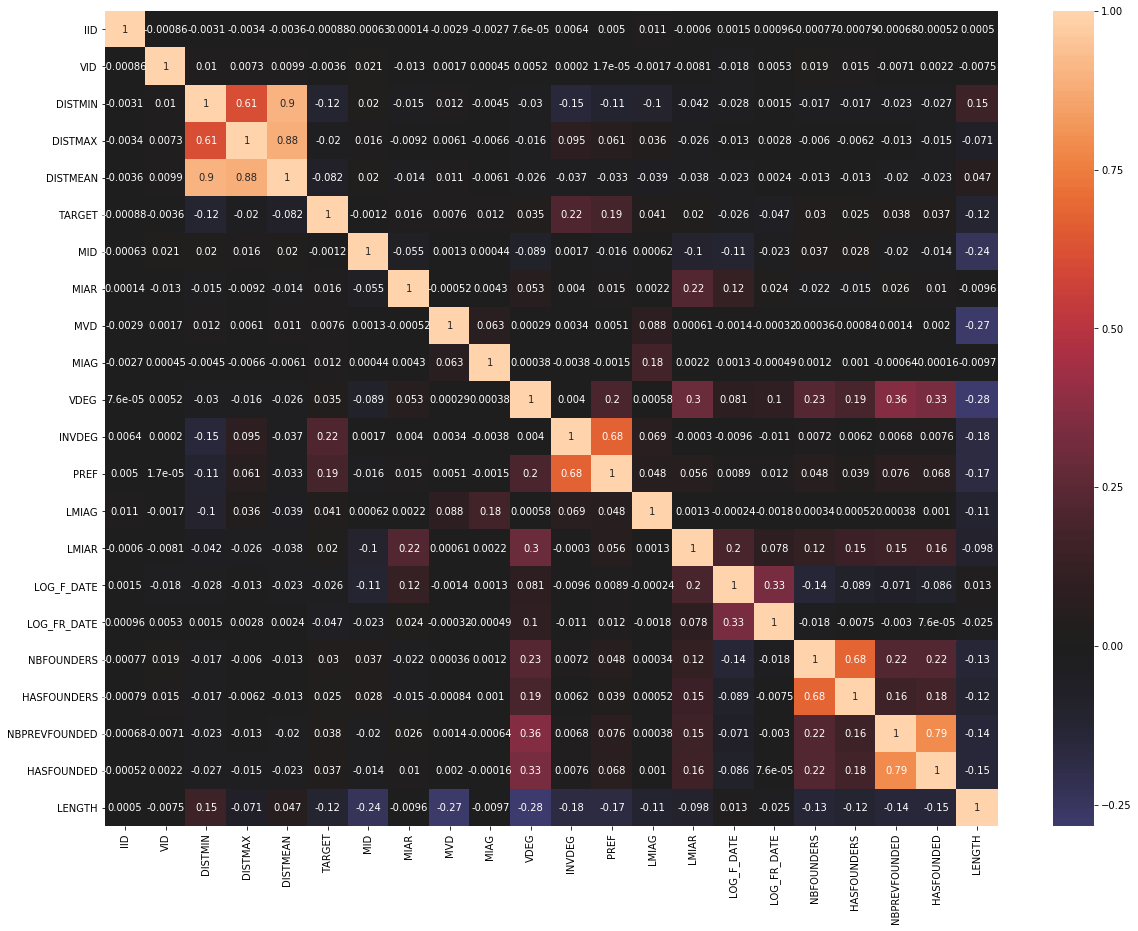

In [5]:
plt.figure(figsize=(20,15))
sn.heatmap(DFA.corr(), annot=True, center=0)

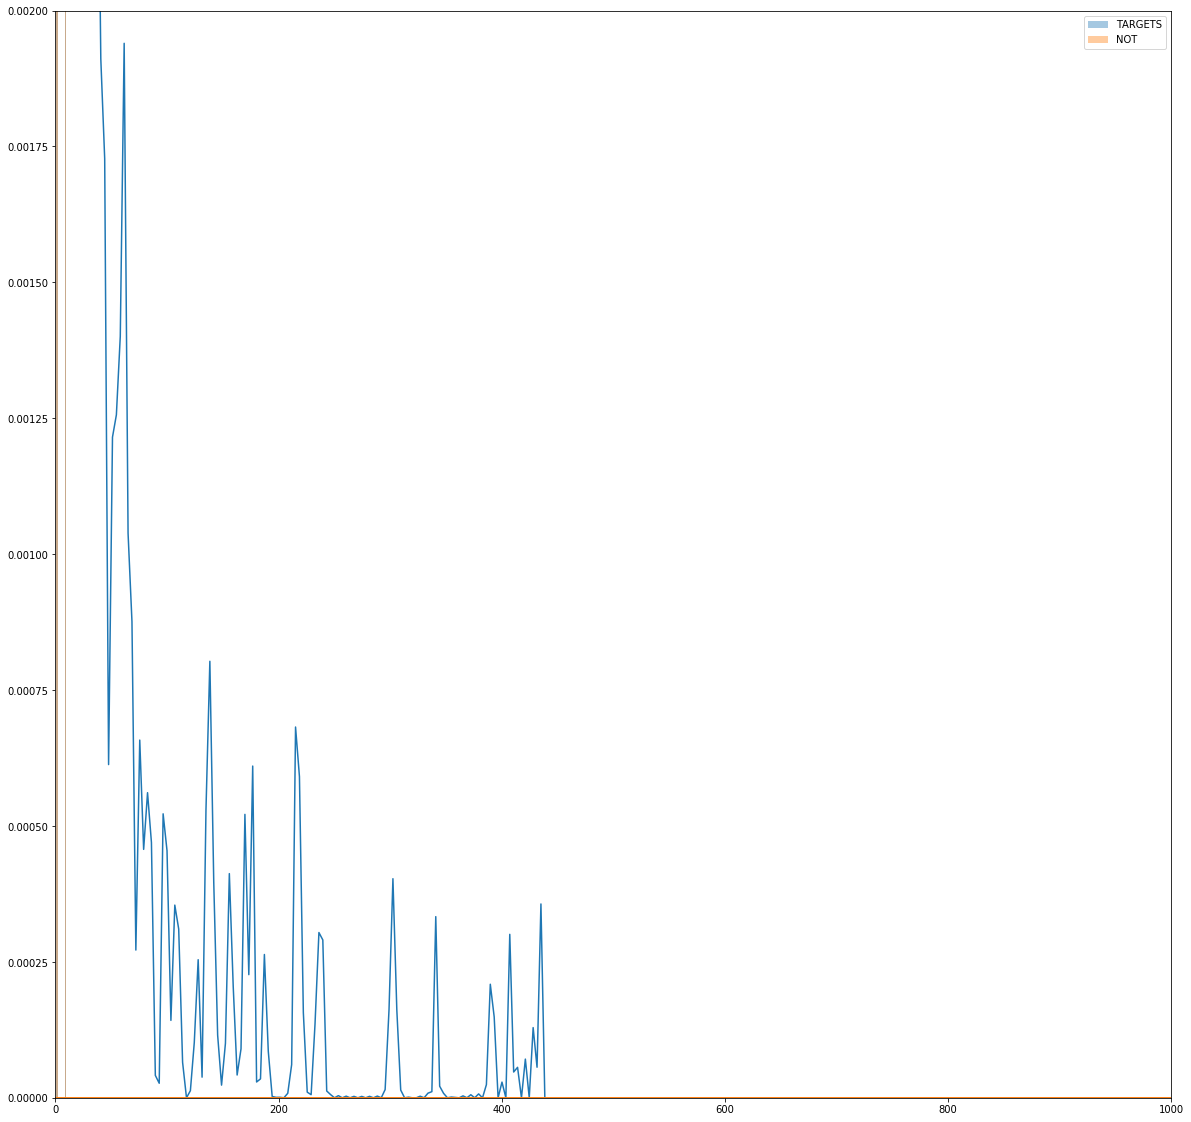

In [40]:
plt.figure(figsize=(20,20))
plt.ylim(0,0.002)
plt.xlim(0,1000)
X1,y1 = np.unique(DFA[DFA['TARGET'] == 1]['PREF'], return_counts=True)
X2,y2 = np.unique(DFA[DFA['TARGET'] == 0]['PREF'], return_counts=True)
sn.distplot(y1, np.log(X1), label="TARGETS")
sn.distplot(y2,np.log(X2), label="NOT")
plt.legend()
plt.show()

In [41]:
DFA[DFA['TARGET'] == 1]['PREF'].mean()

181.6079929237697

In [42]:
DFA[DFA['TARGET'] == 0]['PREF'].mean()

14.445483360201433

# VI - Different Models

In [6]:
['IID', 'VID', 'DISTMIN', 'DISTMAX', 'DISTMEAN', 'TARGET', 'BASE', 'MID',
       'MIAR', 'MVD', 'MIAG', 'VDEG', 'INVDEG', 'PREF', 'LMIAG', 'LMIAR',
       'LOG_F_DATE', 'LOG_FR_DATE', 'NBFOUNDERS', 'HASFOUNDERS',
       'NBPREVFOUNDED', 'HASFOUNDED', 'LENGTH']

Ycolumns = ['IID', 'VID','TARGET', 'MID', 'MIAR', 'MVD', 'MIAG', 'VDEG', 'INVDEG', 'PREF', 'LMIAG', 'LMIAR',
            'LOG_F_DATE', 'LOG_FR_DATE', 'NBFOUNDERS', 'HASFOUNDERS', 'NBPREVFOUNDED', 'HASFOUNDED']
Zcolumns = Ycolumns + ['LENGTH']
Acolumns = Zcolumns + ['DISTMIN', 'DISTMAX', 'DISTMEAN']

In [7]:
models_to_test = [
    {"columns": Ycolumns, "n_estimators":  400, "max_depth": 50, "min_samples_leaf": 1, "n_jobs": NJOBS, "label":"With basic informations"},
    {"columns": Zcolumns, "n_estimators":  400, "max_depth": 50, "min_samples_leaf": 1, "n_jobs": NJOBS, "label":"With Length"},
    {"columns": Ycolumns + ['DISTMIN', 'DISTMAX', 'DISTMEAN'], 
                          "n_estimators":  400, "max_depth": 50, "min_samples_leaf": 1, "n_jobs": NJOBS, "label":"With W2V Columns"},
    {"columns": Acolumns, "n_estimators":  400, "max_depth": 50, "min_samples_leaf": 1, "n_jobs": NJOBS, "label":"With Both W2V and LENGTH"},
    
]

models_calculated = []

In [8]:
%%time

DFTARGETS = DFA[DFA['TARGET'] == 1]
FEATURES_TO_REMOVE = ['TARGET','VID','IID']
Ncut = int(DFA.shape[0]*0.8)


Ntargets = DFTARGETS.shape[0]
Ncandidates = DFA.shape[0]
pcTargets = pc(Ntargets, Ncandidates)
print("There are {} TARGETS for {} overall candidates \n so it is approximately {}".format(Ntargets,Ncandidates, pcTargets))

for model in models_to_test :
    print("\n ■ Training ... with \n\t ■..." + model['columns'][-6:].__str__()[1:] + "\n\t ■LABEL : " + model['label']  )
    
    
    DFTRAIN = DFA[:Ncut][model['columns']]
    Xtrain = DFTRAIN.drop(FEATURES_TO_REMOVE, axis=1)
    Ytrain = DFTRAIN['TARGET']
    
    clf_ = RandomForestClassifier(n_estimators=model['n_estimators'], max_depth=model['max_depth'],
                                  min_samples_leaf=model['min_samples_leaf'], n_jobs=model['n_jobs'],
                                 )
    clf_.fit(Xtrain,Ytrain)
    model['TrainedModel']=clf_



There are 12436 TARGETS for 1405662 overall candidates 
 so it is approximately 0.9%

 ■ Training ... with 
	 ■...'LOG_F_DATE', 'LOG_FR_DATE', 'NBFOUNDERS', 'HASFOUNDERS', 'NBPREVFOUNDED', 'HASFOUNDED']
	 ■LABEL : With basic informations

 ■ Training ... with 
	 ■...'LOG_FR_DATE', 'NBFOUNDERS', 'HASFOUNDERS', 'NBPREVFOUNDED', 'HASFOUNDED', 'LENGTH']
	 ■LABEL : With Length

 ■ Training ... with 
	 ■...'HASFOUNDERS', 'NBPREVFOUNDED', 'HASFOUNDED', 'DISTMIN', 'DISTMAX', 'DISTMEAN']
	 ■LABEL : With W2V Columns

 ■ Training ... with 
	 ■...'NBPREVFOUNDED', 'HASFOUNDED', 'LENGTH', 'DISTMIN', 'DISTMAX', 'DISTMEAN']
	 ■LABEL : With Both W2V and LENGTH
CPU times: user 3h 1min 13s, sys: 18.7 s, total: 3h 1min 32s
Wall time: 2h 11min 33s


# Comparison with Zheng's, with and without LENGTH, W2V and Others


■ We can see that RandomForest outperforms Zheng's
1124529  links 
0.9%  of target links 


/home/malaville/.local/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
/home/malaville/.local/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
/home/malaville/.local/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
/home/malaville/.local/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
/home/malaville/.local/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts o

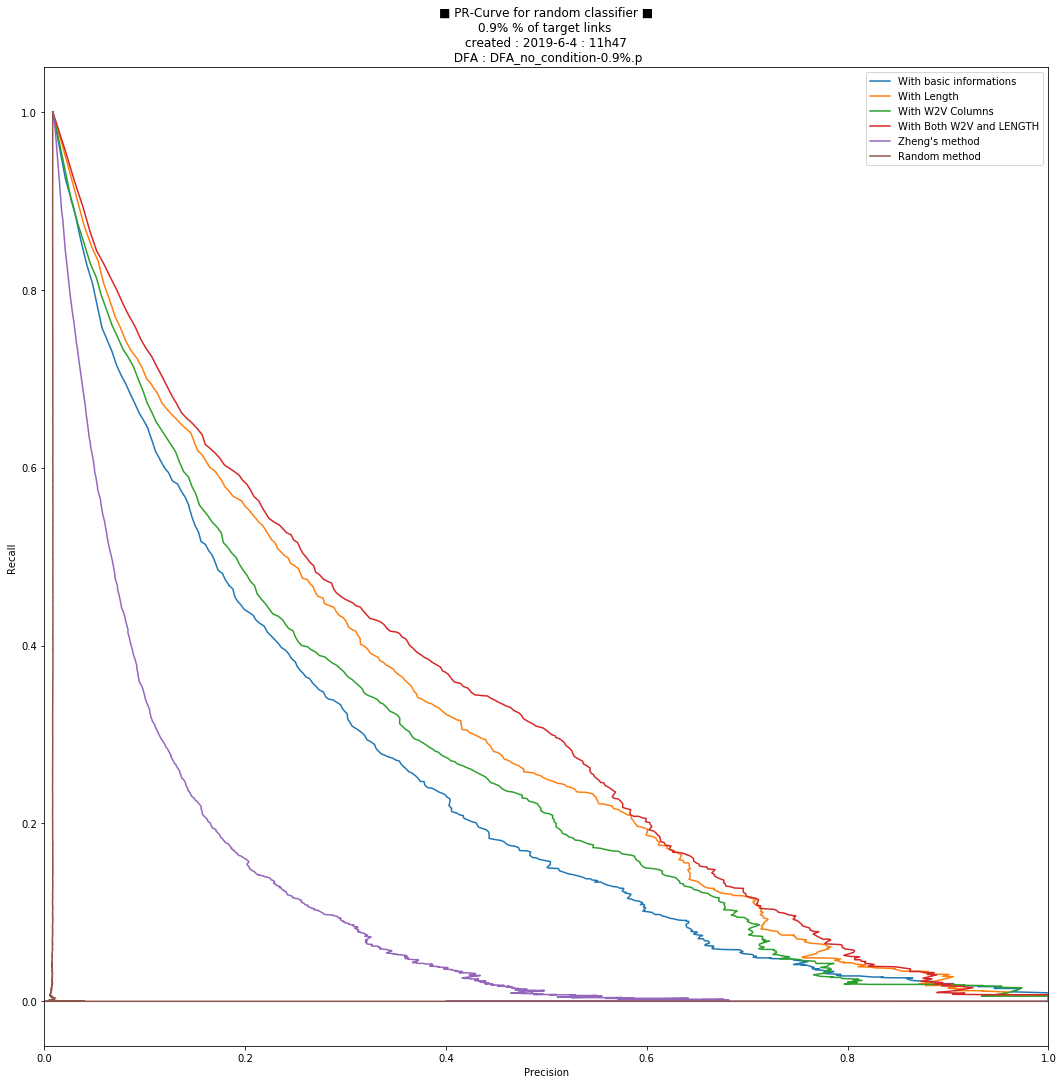

Add any comment to the image ?We can see that we outperform Zheng's, but it wasn't that bad !
■ name of file :  2019-6-4-11h48-0.9pc-[DFA_no_condition-0.9%.p].png


/home/malaville/.local/lib/python3.6/site-packages/ipykernel_launcher.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/malaville/.local/lib/python3.6/site-packages/ipykernel_launcher.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/malaville/.local/lib/python3.6/site-packages/ipykernel_launcher.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/malaville/.local/lib/python3.6/site-packages/ipykernel_launcher.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/malaville/.local/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
/home/malaville/.local/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow wi

CPU times: user 2min 44s, sys: 609 ms, total: 2min 44s
Wall time: 1min 38s


/home/malaville/.local/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
/home/malaville/.local/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
/home/malaville/.local/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
/home/malaville/.local/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
/home/malaville/.local/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts o

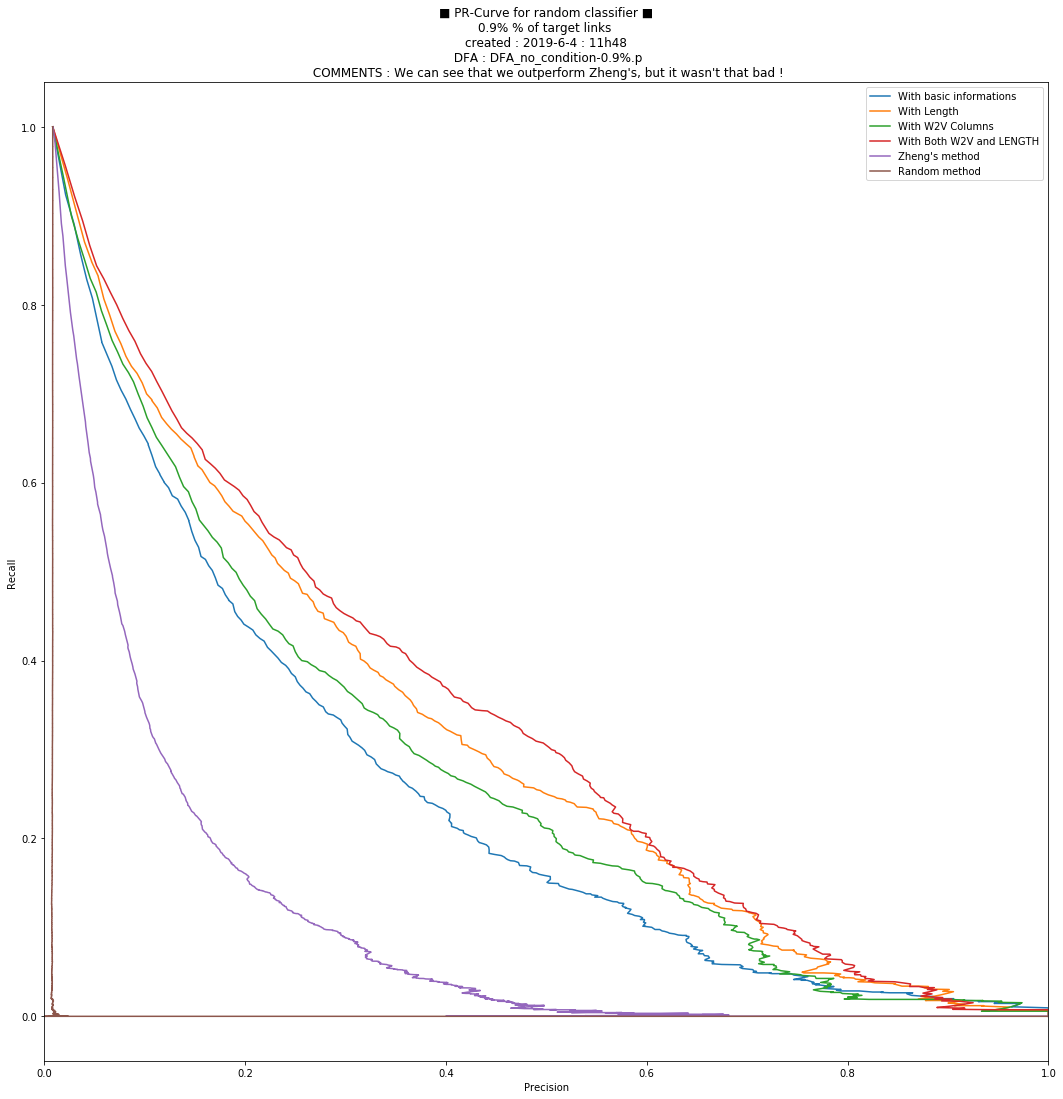

In [43]:
%%time
print("\n■ We can see that RandomForest outperforms Zheng's")
print(DFTRAIN.shape[0], " links ")
print(pc(Ntargets,Ncandidates),  " of target links ")


##############################################


plt.figure(figsize = (18,18))
plt.xlim((0,1))

for model in models_to_test :
    
    DFTEST = DFA[Ncut:][model['columns']]
    Xtest = DFTEST.drop(FEATURES_TO_REMOVE, axis=1)
    Ytest = DFTEST['TARGET']
    
    y_scores = model['TrainedModel'].predict_proba(Xtest)[:, 1]
    p,r,thresholds = precision_recall_curve(Ytest, y_scores)
    plt.plot(p, r, label=model['label'])


zhengs_scores70 = DFTRAIN['PREF']/100
pZ70,rZ70,thresholdsZ70 = precision_recall_curve(Ytrain, zhengs_scores70)
plt.plot(pZ70, rZ70, label='Zheng\'s method')

comparerandomscore = np.random.rand(Ytest.shape[0])
pRand,rRand,thresholdsRand = precision_recall_curve(Ytest, comparerandomscore)
plt.plot(pRand,rRand, label='Random method')


now = datetime.datetime.now()
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.title("■ PR-Curve for random classifier ■\n"
        + pc(Ntargets,Ncandidates) + " % of target links "
        +"\ncreated : {0}-{1}-{2} : {3}h{4}".format(now.year, now.month, now.day, now.hour, now.minute)
        +"\n DFA : " + DFA_chosen)
plt.legend()
plt.show()

###################################### Saving

plt.figure(figsize = (18,18))
plt.xlim((0,1))

for model in models_to_test :
    
    DFTEST = DFA[Ncut:][model['columns']]
    Xtest = DFTEST.drop(FEATURES_TO_REMOVE, axis=1)
    Ytest = DFTEST['TARGET']
    
    y_scores = model['TrainedModel'].predict_proba(Xtest)[:, 1]
    p,r,thresholds = precision_recall_curve(Ytest, y_scores)
    plt.plot(p, r, label=model['label'])


zhengs_scores70 = DFTRAIN['PREF']/100
pZ70,rZ70,thresholdsZ70 = precision_recall_curve(Ytrain, zhengs_scores70)
plt.plot(pZ70, rZ70, label='Zheng\'s method')

comparerandomscore = np.random.rand(Ytest.shape[0])
pRand,rRand,thresholdsRand = precision_recall_curve(Ytest, comparerandomscore)
plt.plot(pRand,rRand, label='Random method')


comment = input("Add any comment to the image ?")
now = datetime.datetime.now()
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.title("■ PR-Curve for random classifier ■\n"
        + pc(Ntargets,Ncandidates) + " % of target links "
        +"\ncreated : {0}-{1}-{2} : {3}h{4}".format(now.year, now.month, now.day, now.hour, now.minute)
        +"\n DFA : " + DFA_chosen
        +"\n COMMENTS : " + comment)
plt.legend()
name = "{0}-{1}-{2}-{3}h{4}".format(now.year, now.month, now.day, now.hour, now.minute)
name += "-" + str(round(100*DFTRAIN['TARGET'].sum()/DFTRAIN.shape[0],1)) + "pc-"
name += "[{}]".format(DFA_chosen)
name+= ".png"
print("■ name of file : " , name)
plt.savefig("./output_data/" + name )
